In [1]:
# 引入必要的库
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [2]:
import timm
import os
import h5py
import numpy as np
import torch
from sklearn.model_selection import KFold
from torch.utils.data import Dataset,DataLoader
from baselines.ViT.ViT_LRP_copy import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP
import warnings
warnings.filterwarnings('ignore')
import os
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [3]:
class MyDataset(Dataset):
    def __init__(self, vit_data,emotion,gambling,language,motor,relational,social,wm):
        self.emotion=[os.path.join(emotion,str(item)+'.mat') for item in vit_data]
        self.gambling=[os.path.join(gambling,str(item)+'.mat') for item in vit_data]
        self.language=[os.path.join(language,str(item)+'.mat') for item in vit_data]
        self.motor=[os.path.join(motor,str(item)+'.mat') for item in vit_data]
        self.relational=[os.path.join(relational,str(item)+'.mat') for item in vit_data]
        self.social=[os.path.join(social,str(item)+'.mat') for item in vit_data]
        self.wm=[os.path.join(wm,str(item)+'.mat') for item in vit_data]
        self.data=self.emotion+self.gambling+self.language+self.motor+self.relational+self.social+self.wm
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        image=self.data[idx]
        image=h5py.File(image,'r')
        image = np.array(image['fc_matrix'])
        image=torch.from_numpy(image).float()
        if self.data[idx] in self.emotion:
            label=torch.tensor(0)
        elif self.data[idx] in self.gambling:
            label=torch.tensor(1)
        elif self.data[idx] in self.language:
            label=torch.tensor(2)
        elif self.data[idx] in self.motor:
            label=torch.tensor(3)
        elif self.data[idx] in self.relational:
            label=torch.tensor(4)
        elif self.data[idx] in self.social:
            label=torch.tensor(5)
        else:
            label=torch.tensor(6)
        return image,label

In [4]:
model = vit_LRP(pretrained=False,num_classes=7,in_chans=1)
model.patch_embed=torch.nn.Linear(155,model.pos_embed.shape[2])
model.pos_embed=torch.nn.Parameter(torch.zeros(1, 155+1, model.pos_embed.shape[2]))
CLS2IDX =  ['emotion','gambling','language','motor','relational','social','wm']
actual_label = []
pred_label = []
data = os.listdir('/media/D/zephyr/functional_connectivity/CHCP/aparc/percent_0.15/Emotion')
data = [int(i[0:4]) for i in data]
data = np.array(sorted(data))
for random_state_num in range(1998,2004):
    kf=KFold(n_splits=5,shuffle=True,random_state=random_state_num)
    percent_value = [0.15,0.2,0.25,0.3]
    for percent in range(1,2):
        print('start percent divide:{} {}'.format(random_state_num,percent_value[percent]))
        for k,(train_index, test_index) in list(enumerate(kf.split(data))):
            emotion="/media/D/zephyr/functional_connectivity/CHCP/aparc/percent_{}/Emotion".format(percent_value[percent])
            gambling="/media/D/zephyr/functional_connectivity/CHCP/aparc/percent_{}/Gambling".format(percent_value[percent])
            language="/media/D/zephyr/functional_connectivity/CHCP/aparc/percent_{}/Language".format(percent_value[percent])
            motor="/media/D/zephyr/functional_connectivity/CHCP/aparc/percent_{}/Motor".format(percent_value[percent])
            relational="/media/D/zephyr/functional_connectivity/CHCP/aparc/percent_{}/Relation".format(percent_value[percent])
            social="/media/D/zephyr/functional_connectivity/CHCP/aparc/percent_{}/Social".format(percent_value[percent])
            wm="/media/D/zephyr/functional_connectivity/CHCP/aparc/percent_{}/Nback".format(percent_value[percent])
            print('=' * 50)
            dataset = MyDataset(data[test_index],emotion,gambling,language,motor,relational,social,wm)
            dataloader=DataLoader(dataset,batch_size =1, shuffle=False)
            model.load_state_dict(torch.load('/media/D/zephyr/vit_155_155/other_map/aparc_chcp_path/rondom_{}_{}_{}_new.pth'.
                                            format(random_state_num,int(percent_value[percent]*100),k),map_location=torch.device('cpu')))
            model=model.to(device)
            model.eval()
            for image,label in dataloader:
                actual_label.append(label_binarize(label, classes=[0, 1, 2, 3, 4, 5, 6])[0])
                image=image.to(device)
                label=label.to(device)
                pred=model(image)
                pred_label.append(pred[0].cpu().detach().numpy())

start percent divide:1998 0.2
start percent divide:1999 0.2
start percent divide:2000 0.2
start percent divide:2001 0.2
start percent divide:2002 0.2
start percent divide:2003 0.2


In [5]:
n_classes=7
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(actual_label)[:, i], np.array(pred_label)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [6]:
fpr["micro"], tpr["micro"], _ = roc_curve(np.array(actual_label).ravel(), np.array(pred_label).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [7]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

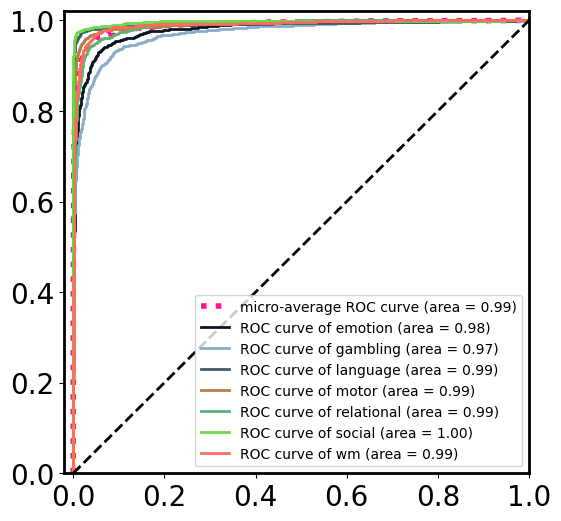

In [8]:
CLS2IDX =  ['emotion','gambling','language','motor','relational','social','wm']
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
 
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
 
# Plot all ROC curves
lw=2
fig,ax = plt.subplots(figsize=(6,6))    
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['#0c1424', '#8aaccb', '#47576e','#bc7b42','#5db372','#6ddb46','#fb6e5e'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(CLS2IDX[i], roc_auc[i]))
 
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
ax.spines['right'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
# plt.xlabel('False Positive Rate',fontsize=30)
# plt.ylabel('True Positive Rate',fontsize=30)
plt.legend(loc="lower right")
plt.savefig("/media/D/zephyr/vit_155_155/picture_new/chcp_auc.svg".format(percent), dpi=300,format="svg")